## 감성분석

#### 주관적 단어와 문맥을 기분으로 감성 수치를 계산

#### 지도, 비지도 두 가지 방법 존재 

### (1) 지도학습 실습

In [ ]:
import pandas as pd

# tsv란 탭(\t)문자로 분리된 파일

review_df = pd.read_csv('/content/drive/MyDrive/파머완/labeledTrainData.tsv', header=0,sep="\t", quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [ ]:
print(review_df['review'][1])

"\"The Classic War of the Worlds\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \"critics\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \"critics\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \"critics\" perceive to be its shortcomings."


In [ ]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />',' ')

# 파이썬의 정규 표현식 모듈인 re를 이용하여 영어 문자열이 아닌 문자는 모두 공백으로 변환 
review_df['review'] = review_df['review'].apply( lambda x : re.sub("[^a-zA-Z]", " ", x))

In [ ]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(columns=['id','sentiment'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3,
                                                    random_state=156)

X_train.shape, X_test.shape

((17500, 1), (7500, 1))

#### countvectorizer를 이용한 예측

##### n-gram은 연속된 n개의 단어를 의미합니다. 예를 들어, "I love machine learning"이라는 문장에서 bigram(2-gram)을 추출하면 "I love", "love machine", "machine learning"이 됩니다. CountVectorizer에서는 ngram_range 파라미터를 사용하여 생성할 n-gram 범위를 지정할 수 있습니다.

ngram_range 파라미터는 (min_n, max_n) 형태의 튜플로 지정하며, CountVectorizer는 min_n부터 max_n까지의 모든 n-gram을 생성합니다. 예를 들어, ngram_range=(1,2)는 단어의 유니그램(unigram)과 바이그램(bigram)을 모두 생성하도록 설정합니다. 따라서 CountVectorizer가 생성한 단어장은 유니그램과 바이그램으로 구성됩니다.

n-gram은 문맥을 고려한 특징 추출에 유용합니다. 예를 들어, "not good"과 "very good"은 모두 "good"이라는 단어를 포함하지만, 두 문장에 대해 전혀 다른 감정을 나타냅니다. 유니그램만 사용하면 이러한 문맥 정보를 놓치게 될 수 있지만, 바이그램을 사용하면 문맥 정보를 반영할 수 있습니다.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, filtering, ngram은 (1,2)로 설정해 CountVectorization수행. 
# LogisticRegression의 C는 10으로 설정. 
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2) )), #stop_words는 불용어 제거, 
    ('lr_clf', LogisticRegression(C=10))]) #C는 모델 복잡도 파라미터 

# Pipeline 객체를 이용하여 fit(), predict()로 학습/예측 수행. predict_proba()는 roc_auc때문에 수행.  
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도는 0.8860, ROC-AUC는 0.9503


#### tfidf를 이용한 예측

In [ ]:
# 스톱 워드는 english, filtering, ngram은 (1,2)로 설정해 TF-IDF 벡터화 수행. 
# LogisticRegression의 C는 10으로 설정. 
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10))])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


### (2) 비지도 학습 기반 예측

#### Lexicon을 기반으로 함. 레이블이 없을 떄 사용 (한글 지원은 안해준대)

##### 시맨틱: 문맥상의 의미 (예시: present가 현재인지, 선물인지 구분)

##### WordNet은 시맨틱 분석을 제공하는 어휘사전

##### Synset: 그 단어가 가지는 문맥, 시맨틱 정보를 제공하는 WordNet의 핵심 개념

##### nltk는 사전 역할은 잘하지만, 예측 성능이 안좋아, 예측에선 다른 감성 사전을 적용함

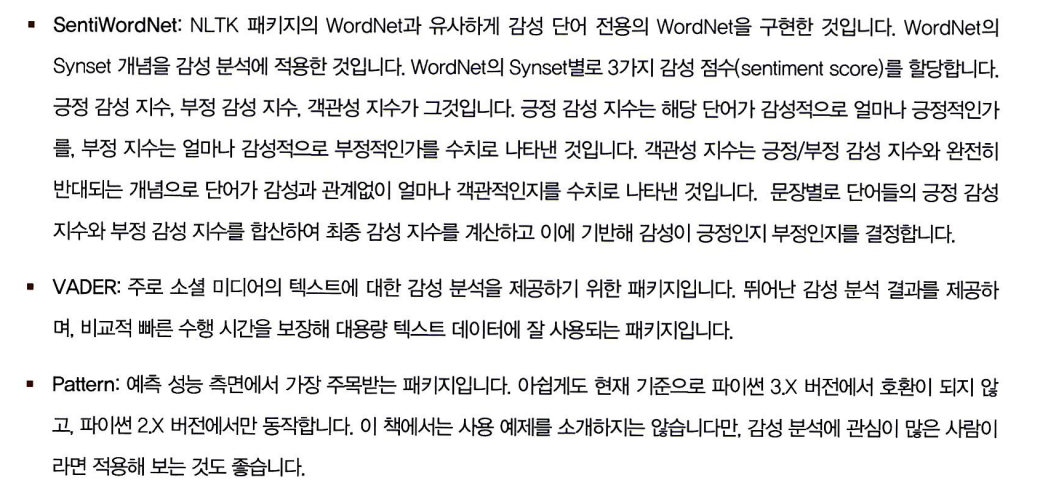

#### (2-1) SentiWordNet 예시

##### 품사, 뜻의 개수 등 반환환

In [ ]:
import nltk
nltk.download('all')

In [ ]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성. 
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 갯수:', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 갯수: 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


##### present.n.01은 POS 태그. present는 의미, n은 명사 품사, 01은 명사로써 가지는 여러가지 의미중 1번쨰 의미

In [ ]:
for synset in synsets :
    print('##### Synset name : ', synset.name(),'#####')
    print('POS :',synset.lexname())
    print('Definition:',synset.definition())
    print('Lemmas:',synset.lemma_names())

##### Synset name :  present.n.01 #####
POS : noun.time
Definition: the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas: ['present', 'nowadays']
##### Synset name :  present.n.02 #####
POS : noun.possession
Definition: something presented as a gift
Lemmas: ['present']
##### Synset name :  present.n.03 #####
POS : noun.communication
Definition: a verb tense that expresses actions or states at the time of speaking
Lemmas: ['present', 'present_tense']
##### Synset name :  show.v.01 #####
POS : verb.perception
Definition: give an exhibition of to an interested audience
Lemmas: ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name :  present.v.02 #####
POS : verb.communication
Definition: bring forward and present to the mind
Lemmas: ['present', 'represent', 'lay_out']
##### Synset name :  stage.v.01 #####
POS : verb.creation
Definition: perform (a play), especially on a stage
Lemmas: ['stage', 'present', 'represen

In [ ]:
# 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타낼 수도 있음

# synset 객체를 단어별로 생성합니다. 
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree , lion , tiger , cat , dog]
similarities = []
entity_names = [ entity.name().split('.')[0] for entity in entities]

# 단어별 synset 들을 iteration 하면서 다른 단어들의 synset과 유사도를 측정합니다. 
for entity in entities:
    similarity = [ round(entity.path_similarity(compared_entity), 2)  for compared_entity in entities ] #entity와 compared_entity 간의 유사도 계산 
    similarities.append(similarity)
    
# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame형태로 저장합니다.  
similarity_df = pd.DataFrame(similarities , columns=entity_names,index=entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


#### (2-2) SentiSynset 예시

##### 감성지수, 객관성 지수 출력

In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 갯수:', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 갯수: 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수: ', father.pos_score())
print('father 부정감성 지수: ', father.neg_score())
print('father 객관성 지수: ', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ',fabulous .pos_score())
print('fabulous 부정감성 지수: ',fabulous .neg_score())

father 긍정감성 지수:  0.0
father 부정감성 지수:  0.0
father 객관성 지수:  1.0


fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125


#### (2-3) SentiWordNet를 이용한 영화 감상평 분석

- 문서를 문장 단위로 분해
- 다시 문장을 단어단위로 토큰화하고 품사 태깅
- 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
- Senti_synset에서 긍정, 부정지수 구함, 이를 합산해 특정 임계값 이상일 때, 긍정 아니면 부정 결정

In [ ]:
# 방법 실행전, 품사 태깅을 수행하는 내부 함수 생성성
from nltk.corpus import wordnet as wn

# 간단한 NTLK PennTreebank Tag를 기반으로 WordNet기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return 

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화 
    sentiment = 0.0
    tokens_count = 0
    
    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산 
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출  
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word , tag in tagged_sentence:
            
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                continue                   
            lemma = lemmatizer.lemmatize(word, pos=wn_tag) #입력된 단어(word)를 워드넷 기반 품사 태깅(pos)을 이용해 어근 형태로 변환
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성. 
            synsets = wn.synsets(lemma , pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산. 
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())           
            tokens_count += 1
    
    if not tokens_count:
        return 0
    
    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1
    
    return 0

In [ ]:
review_df['preds'] = review_df['review'].apply( lambda x : swn_polarity(x) )
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
print('#### SentiWordNet 예측 성능 평가 ####')
get_clf_eval(y_target, preds)

#### SentiWordNet 예측 성능 평가 ####
오차 행렬
[[7668 4832]
 [3636 8864]]
정확도: 0.6613, 정밀도: 0.6472, 재현율: 0.7091,    F1: 0.6767, AUC:0.6613


#### (2-4) VADER를 이용한 감성분석

- 소셜미디어의 감성분석 용도

In [ ]:
# 별도의 모듈을 설치하려면
# pip install vaderSentiment
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


- neg: 부정
- neu: 중립
- pos: 긍정
- 보통 0.1 이상이면 긍정, 그 이하이면 부정

In [ ]:
def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환 
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply( lambda x : vader_polarity(x, 0.1) )
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print('#### VADER 예측 성능 평가 ####')
get_clf_eval(y_target, vader_preds)

#### VADER 예측 성능 평가 ####
오차 행렬
[[ 6747  5753]
 [ 1858 10642]]
정확도: 0.6956, 정밀도: 0.6491, 재현율: 0.8514,    F1: 0.7366, AUC:0.6956


## 토픽 모델링

- 문서 집합에 숨어 있는 주제를 찾는 것

In [43]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 의학, 우주 주제를 추출. 
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med'  ]

# 위에서 cats 변수로 기재된 category만 추출. featch_20newsgroups( )의 categories에 cats 입력
news_df= fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'), 
                            categories=cats, random_state=0)

#LDA 는 Count기반의 Vectorizer만 적용합니다.  
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [44]:
# 토픽의 개수는 위 뉴스그룹에서 추출한 주제와 동일한 8개로 지정

lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

In [ ]:
# 값이 클수록 해당 word 피처는 그 토픽픽의 중심 word임
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [48]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names_out( )를 통해 추출
feature_names = count_vect.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run
